In [3]:
%load_ext autoreload
%autoreload 2
# Enable imports form top-level of project (edit top_level_path accordingly)
import os
import sys
import inspect

top_level_path = os.path.abspath(os.path.join('..'))
if top_level_path not in sys.path:
	sys.path.append(top_level_path)

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from longestpath.gen import gen_num_edges
from benchmarking import RandomParams, Benchmark, new_random_benchmark, Solver, new_graph_file_benchmark, new_benchmark
import re

In [3]:
def generate():
  return [
    gen_num_edges(50, round(50 * degree/2))
      for degree in np.arange(1, 4.0, 0.2) for _ in range(100)
  ]

params_code = inspect.getsource(generate)
graphs = generate()

benchmark = new_benchmark(graphs, solvers=[
	Solver("brute", "FAST_BOUND"),
	Solver("brute", "BRUTE_FORCE"),
], params_code = params_code, override_benchmark_path="../benchmarks/test")

benchmark.benchmark_path


'../benchmarks/test(15)'

In [6]:
benchmark = Benchmark.load("../benchmarks/test(15)")

In [4]:
benchmark.run(retryFailures=False, timeout=10)


graph: 0.txt, solver: brute('FAST_BOUND') ... ✅
length: 4, run_time: 8e-06
graph: 1.txt, solver: brute('FAST_BOUND') ... 

✅
length: 3, run_time: 7e-06
graph: 2.txt, solver: brute('FAST_BOUND') ... ✅
length: 3, run_time: 7e-06
graph: 3.txt, solver: brute('FAST_BOUND') ... ✅
length: 5, run_time: 8e-06
graph: 4.txt, solver: brute('FAST_BOUND') ... ✅
length: 4, run_time: 7e-06
graph: 5.txt, solver: brute('FAST_BOUND') ... ✅
length: 4, run_time: 7e-06
graph: 6.txt, solver: brute('FAST_BOUND') ... ✅
length: 2, run_time: 8e-06
graph: 7.txt, solver: brute('FAST_BOUND') ... ✅
length: 4, run_time: 8e-06
graph: 8.txt, solver: brute('FAST_BOUND') ... ✅
length: 5, run_time: 7e-06
graph: 9.txt, solver: brute('FAST_BOUND') ... ✅
length: 6, run_time: 6e-06
graph: 10.txt, solver: brute('FAST_BOUND') ... ✅
length: 5, run_time: 7e-06
graph: 11.txt, solver: brute('FAST_BOUND') ... ✅
length: 2, run_time: 7e-06
graph: 12.txt, solver: brute('FAST_BOUND') ... ✅
length: 3, run_time: 7e-06
graph: 13.txt, solver: brute('FAST_BOUND') ... ✅
length: 4, run_time: 7e-06
graph: 14.txt, solver: brute('FAST_BOUND') ... ✅
length: 3, run_tim

In [7]:
# name = os.path.splitext(os.path.basename(benchmark.benchmark_path))[0]

results = benchmark.results()
solver_names = [str(solver) for solver in benchmark.solvers]
graph_infos = benchmark.info["graph_infos"]
# pd.DataFrame(results)
solver_names

df = pd.DataFrame(results)
df["solver_name"] = df["solver"].apply(lambda i: solver_names[i])


In [8]:
graph_data = pd.DataFrame([{"id" : id, "vertices": graph.vertices, "edges": len(graph.edges)} for id, graph in benchmark.graphs])
graph_data["average_degree"] = 2 * graph_data["edges"] / graph_data["vertices"]

graph_data

,id,vertices,edges,average_degree
0,0,50,25,1.0
1,1,50,25,1.0
2,2,50,25,1.0
3,3,50,25,1.0
4,4,50,25,1.0
...,...,...,...,...
1495,1495,50,95,3.8
1496,1496,50,95,3.8
1497,1497,50,95,3.8
1498,1498,50,95,3.8


In [9]:
df = pd.merge(df, graph_data, left_on="graph_id", right_on="id")
df

,path,run_time,length,solver,graph_id,solver_name,id,vertices,edges,average_degree
0,"[32, 39, 0, 10, 35]",0.000008,4,0,0,brute('FAST_BOUND'),0,50,25,1.0
1,"[24, 16, 36, 12]",0.000007,3,0,1,brute('FAST_BOUND'),1,50,25,1.0
2,"[30, 39, 35, 16]",0.000007,3,0,2,brute('FAST_BOUND'),2,50,25,1.0
3,"[35, 48, 36, 0, 41, 7]",0.000008,5,0,3,brute('FAST_BOUND'),3,50,25,1.0
4,"[6, 36, 30, 18, 13]",0.000007,4,0,4,brute('FAST_BOUND'),4,50,25,1.0
...,...,...,...,...,...,...,...,...,...,...
2995,"[32, 13, 18, 10, 12, 2, 4, 20, 27, 24, 49, 25,...",0.000226,23,1,1495,brute('BRUTE_FORCE'),1495,50,95,3.8
2996,"[45, 13, 5, 34, 24, 15, 6, 40, 9, 26, 38, 12, ...",0.000525,27,1,1496,brute('BRUTE_FORCE'),1496,50,95,3.8
2997,"[28, 17, 20, 38, 30, 8, 44, 42, 10, 29, 16, 37...",0.007366,33,1,1497,brute('BRUTE_FORCE'),1497,50,95,3.8
2998,"[30, 20, 33, 32, 36, 28, 21, 39, 10, 12, 16, 3...",0.002212,27,1,1498,brute('BRUTE_FORCE'),1498,50,95,3.8


run_time    Axes(0.125,0.11;0.775x0.77)
dtype: object

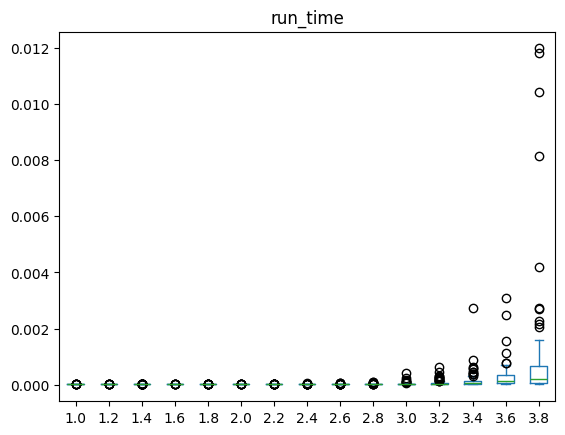

In [10]:
df[df["solver"] == 0][["run_time", "average_degree"]].plot.box(by="average_degree", logy=True)


In [8]:
view = df[['average_degree', 'solver_name','length', 'run_time']]

to_plot = df.groupby(['average_degree', 'solver', 'solver_name']).agg({'run_time': 'mean'}).reset_index() \
    .pivot(index='average_degree', columns='solver_name', values='run_time') \
    .rename(columns=lambda x: x + " (average)");


df

,path,run_time,length,solver,graph_id,solver_name,id,vertices,edges,average_degree
0,"[32, 39, 0, 10, 35]",0.000008,4,0,0,brute('FAST_BOUND'),0,50,25,1.0
1,"[24, 16, 36, 12]",0.000007,3,0,1,brute('FAST_BOUND'),1,50,25,1.0
2,"[30, 39, 35, 16]",0.000007,3,0,2,brute('FAST_BOUND'),2,50,25,1.0
3,"[35, 48, 36, 0, 41, 7]",0.000008,5,0,3,brute('FAST_BOUND'),3,50,25,1.0
4,"[6, 36, 30, 18, 13]",0.000007,4,0,4,brute('FAST_BOUND'),4,50,25,1.0
...,...,...,...,...,...,...,...,...,...,...
2995,"[32, 13, 18, 10, 12, 2, 4, 20, 27, 24, 49, 25,...",0.000226,23,1,1495,brute('BRUTE_FORCE'),1495,50,95,3.8
2996,"[45, 13, 5, 34, 24, 15, 6, 40, 9, 26, 38, 12, ...",0.000525,27,1,1496,brute('BRUTE_FORCE'),1496,50,95,3.8
2997,"[28, 17, 20, 38, 30, 8, 44, 42, 10, 29, 16, 37...",0.007366,33,1,1497,brute('BRUTE_FORCE'),1497,50,95,3.8
2998,"[30, 20, 33, 32, 36, 28, 21, 39, 10, 12, 16, 3...",0.002212,27,1,1498,brute('BRUTE_FORCE'),1498,50,95,3.8


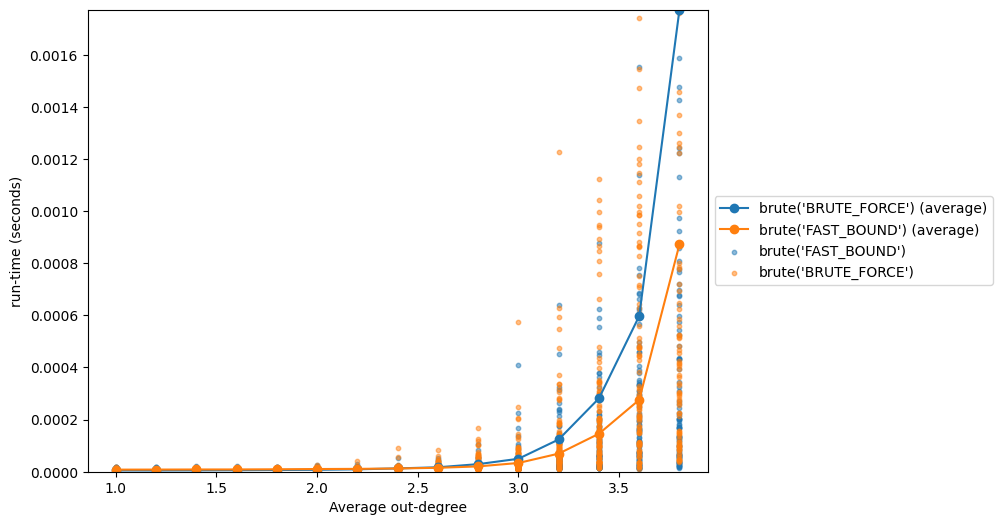

In [32]:
to_plot.plot(style="o-")

for solver_name in solver_names:
    solver_df = df[df["solver_name"] == solver_name]  # Select rows where run-time is not null
    plt.scatter(solver_df['average_degree'], solver_df['run_time'], label=solver_name, alpha=0.5, s=10)

# plt.yscale('log')
# plt.xticks(np.arange(1, 4.0, 0.5))
plt.ylabel("run-time (seconds)")
plt.xlabel("Average degree")
# plt.title("Longest path solve-time for random directed graphs with 50 vertices")
# plt.axhline(y=0.015, color='black', linestyle='--', label='run-time cutoff', linewidth=1, alpha=0.5, zorder=0)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# df[df["solver"] == 0].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
# df[df["solver"] == 1].plot(x = "average_degree", y="run_time", style="--bo", label="solver_name")
plt.ylim(0, to_plot.max().max())

plt.gcf().set_size_inches(8, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')

In [22]:
to_plot2 = df.groupby("solver").get_group(0)[["run_time", "average_degree"]].sort_values(by="average_degree")
to_plot2


,run_time,average_degree
0,0.000008,1.0
72,0.000008,1.0
71,0.000008,1.0
70,0.000007,1.0
69,0.000012,1.0
...,...,...
1427,0.000033,3.8
1426,0.000059,3.8
1424,0.000046,3.8
1435,0.000054,3.8


<Axes: xlabel='average_degree'>

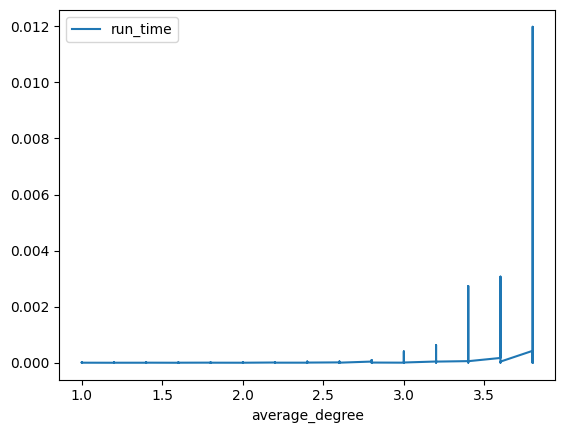

In [23]:
to_plot2.plot(x="average_degree", y="run_time")

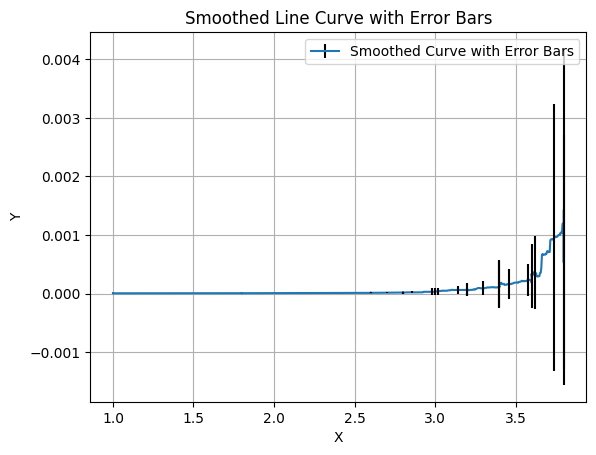

In [25]:
rolling_window = 50
df_smoothed = to_plot2.rolling(rolling_window, center=True).mean()
df_std = to_plot2.rolling(rolling_window, center=True).std()

# Plot the smoothed curve with error bars
plt.errorbar(df_smoothed['average_degree'], df_smoothed['run_time'], yerr=df_std['run_time'], label='Smoothed Curve with Error Bars', errorevery=30, barsabove=True, ecolor="black")
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Smoothed Line Curve with Error Bars')
plt.legend()
plt.grid(True)
plt.show()

In [121]:
benchmark = Benchmark.load("../benchmarks/rob-top2000")
name = os.path.splitext(os.path.basename(benchmark.benchmark_path))[0]

results = benchmark.results()
solver_names = [str(solver) for solver in benchmark.solvers]
graph_infos = benchmark.info["graph_infos"]

df = pd.DataFrame(results)
df["solver_name"] = df["solver"].apply(lambda i: solver_names[i])

ax = df.plot.bar(x="solver_name", y="run_time") \

for i, value in enumerate(df["run_time"]):
    ax.text(i, value, f'{value:.2f}', ha='center', va='bottom')  # Display value at the top of the bar


ax.tick_params(axis='x', labelrotation=0)
plt.ylabel("run-time (seconds)")
plt.title("Longest path solve-time for Top 2000 songs graph")

plt.gcf().set_size_inches(12, 6)
plt.savefig(os.path.join(benchmark.benchmark_path, "plot.png"), dpi=400, bbox_inches='tight')

FileNotFoundError: [Errno 2] No such file or directory: '../benchmarks/rob-top2000/info.json'